# Simulating 2 trapped bosonic atoms in a 7 site chain under the Bose-Hubbard Hamiltonian

In [4]:
import time
import matplotlib.pyplot as plt
import numpy as np
import qutip

In [5]:
# chain length
L = 7
dim = 2 ** (L)

In [6]:
# time grid
t_f = 25
nt = 3000
times = np.linspace(0, t_f, nt)

## Elastic scattering (propagation of two bosons)

### Constructing ladder operators for a three level system

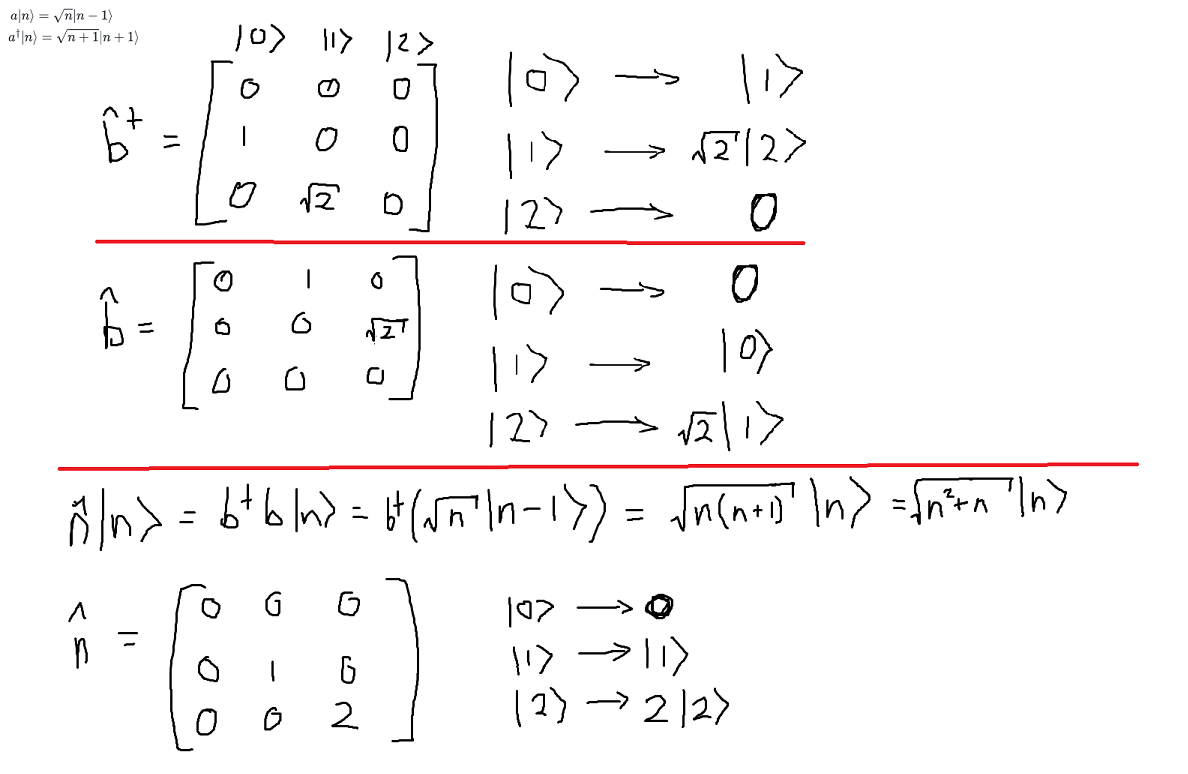

In [7]:
raise_op = np.zeros([3,3])
raise_op[1][0] = 1
raise_op[2][1] = np.sqrt(2)

lower_op = np.zeros([3, 3])
lower_op[0][1] = 1
lower_op[1][2] = np.sqrt(2)

In [8]:
# Following is number operator, it should map:
# |0> --> 0
# |1> --> |1>
# |2> --> 2|2>
raise_op @ lower_op

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 2.]])

In [9]:
class ThreeLvlBoseHubbard:
    def __init__(self, L: int, t: float, U: float, mu: float):
        self.L = L
        self.t = t
        self.U = U
        self.mu = mu
        
        # Utility objects
        self.raise_op = np.zeros([3,3])
        self.raise_op[1][0] = 1
        self.raise_op[2][1] = np.sqrt(2)
        self.raise_op = qutip.Qobj(self.raise_op)
        
        self.lower_op = np.zeros([3, 3])
        self.lower_op[0][1] = 1
        self.lower_op[1][2] = np.sqrt(2)
        self.lower_op = qutip.Qobj(self.lower_op)
    
    ### Get hamiltonian
    def get_hamiltonian(self):
        """Returns the Bose-Hubbard Hamiltonian for specified t, U, mu 
           formulation: https://en.wikipedia.org/wiki/Bose%E2%80%93Hubbard_model 
             Args:
                 - (float) t: hopping term coefficient
                 - (float) U: on-site interaction strength
                 - (float) mu: chemical potential
             Returns:
                - (qutip.Qobj) Hamiltonian matrix for specified params
            *Note that large U/t induces the hard-core boson constraint
         """
        t = self.t
        U = self.U
        mu = self.mu
        hopping_terms = [self.raise_at(i)*self.lower_at(i+1) \
                         + self.raise_at(i+1)*self.lower_at(i) for i in range(L-1)]
        
        on_site_interactions = [self.number_at(i)*self.number_at(i) \
                                - self.number_at(i) for i in range(L)]
        
        chemical_potentials = [self.number_at(i) for i in range(L)]
        
        hamiltonian = -t*sum(hopping_terms) +U/2*sum(on_site_interactions) -mu*sum(chemical_potentials) 
        self.H = hamiltonian
        return hamiltonian

    ### Utility methods
    def raise_at(self, i: int):
        """Returns the creation operator applied at site i: \hat{b}^{\dagger}_i """
        if i > self.L:
            raise ValueError("Site index must be less than chain length")
        
        op = [self.raise_op if k == i else qutip.qutip.qeye(3) for k in range(self.L)]
        return qutip.tensor(op)
    
    def lower_at(self, i: int):
        """Returns the annihilation operator applied at site i: \hat{b}_i """
        if i > self.L:
            raise ValueError("Site index must be less than chain length")
        
        op = [self.lower_op if k == i else qutip.qutip.qeye(3) for k in range(self.L)]
        return qutip.tensor(op)
    
    def number_at(self, i: int):
        """Returns the particle number operator applied at site i: \hat{n}_i"""
        if i > self.L:
            raise ValueError("Site index must be less than chain length")
        return self.raise_at(i) * self.lower_at(i)

### Build Hamiltonian and evolve

In [12]:
MHz = 1e6 # affects the rate of system evolution, in MHz to mimic real experiment
mus = 1e-6 # time scale at which real experiments operate

In [28]:
J = 0.5 *MHz # Arbitrary value

zero = qutip.basis(3, 0) # |0> zero occupation
one = qutip.basis(3, 1)  # |1> one occupation
two = qutip.basis(3, 2)  # |2> double occupation

In [14]:
# prepare initial state with an excitation at both ends
L = 7
psi_init = [zero] * L
psi_init[0] = one
psi_init[-1] = one
psi_init = qutip.tensor(psi_init)

In [15]:
# time grid
t_f = 30 * mus# in sec
nt = 3000
times = np.linspace(0, t_f, nt)

In [16]:
# site index to investigate
site_num = int(L/2)
# expectation value of 0, 1, 2 excitations at each site
exp_ops = []
exp_ops.extend([
                qutip.tensor([zero * zero.conj().trans() if k == i else qutip.qeye(3) for k in range(L)])
                for i in range(L)
]) # probability of zero occupation at each site [:7]
exp_ops.extend([
                qutip.tensor([one * one.conj().trans() if k == i else qutip.qeye(3) for k in range(L)])
                for i in range(L)
]) # probability of one occupation at each site [7:14]
exp_ops.extend([
                qutip.tensor([two * two.conj().trans() if k == i else qutip.qeye(3) for k in range(L)])
                for i in range(L)
]) # probability of two occupations at each site [14:]

In [17]:
# Store exp vals in dictionary:
# {
#    "$U/t=0$": [[...], ... , [...] ],
#    "$U/t=1$": [[...], ... , [...] ]
#}
exp_vals = {}

### Simulating $U=0$ 

In [29]:
# generate evolution Hamiltonian with local control
H = ThreeLvlBoseHubbard(L, t=J, U=0*MHz, mu=J)
H = H.get_hamiltonian()

In [30]:
# solve
start = time.time()
result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
timelapsed_elastic = time.time() - start
print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
# store
exp_vals["$U/t=0$"] = np.asarray(result.expect)

4.97 s to simulate elastic scattering in a chain of 7 bosons


### Simulating $U/t = 1$ 

In [29]:
U_to_J = 1

In [30]:
# generate evolution Hamiltonian with local control
U = J * U_to_J
H = ThreeLvlBoseHubbard(L, t=J, U=U, mu=J)
H = H.get_hamiltonian()

In [31]:
# solve
start = time.time()
result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
timelapsed_elastic = time.time() - start
print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
# store
exp_vals["$U/t=1$"] = np.asarray(result.expect)

6.745 s to simulate elastic scattering in a chain of 7 bosons


### Simulating $U/t = 2:9$ 

In [120]:
for U_to_J in range(2,10):
    # generate evolution Hamiltonian with local control
    U = J * U_to_J
    H = ThreeLvlBoseHubbard(L, t=J, U=U, mu=J)
    H = H.get_hamiltonian()

    # solve
    start = time.time()
    result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
    timelapsed_elastic = time.time() - start
    print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
    # store
    key_str = "$U/t=" + str(U_to_J) + "$"
    exp_vals[key_str] = np.asarray(result.expect)

3.934 s to simulate elastic scattering in a chain of 7 bosons
5.478 s to simulate elastic scattering in a chain of 7 bosons
5.373 s to simulate elastic scattering in a chain of 7 bosons
5.407 s to simulate elastic scattering in a chain of 7 bosons
5.461 s to simulate elastic scattering in a chain of 7 bosons
5.447 s to simulate elastic scattering in a chain of 7 bosons
5.377 s to simulate elastic scattering in a chain of 7 bosons
5.526 s to simulate elastic scattering in a chain of 7 bosons


### Simulating $U/t = 10$ 

In [31]:
U_to_J = 10

In [32]:
# generate evolution Hamiltonian with local control
U = J * U_to_J
H = ThreeLvlBoseHubbard(L, t=J, U=U, mu=J)
H = H.get_hamiltonian()

In [33]:
# solve
start = time.time()
result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
timelapsed_elastic = time.time() - start
print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
# store
exp_vals["$U/t=10$"] = np.asarray(result.expect)

7.391 s to simulate elastic scattering in a chain of 7 bosons


### Simulating $U/t = 11:20$ 

In [146]:
for U_to_J in range(11,21):
    # generate evolution Hamiltonian with local control
    U = J * U_to_J
    H = ThreeLvlBoseHubbard(L, t=J, U=U, mu=J)
    H = H.get_hamiltonian()

    # solve
    start = time.time()
    result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
    timelapsed_elastic = time.time() - start
    print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
    # store
    key_str = "$U/t=" + str(U_to_J) + "$"
    exp_vals[key_str] = np.asarray(result.expect)

5.377 s to simulate elastic scattering in a chain of 7 bosons
5.665 s to simulate elastic scattering in a chain of 7 bosons
6.185 s to simulate elastic scattering in a chain of 7 bosons
5.885 s to simulate elastic scattering in a chain of 7 bosons
5.916 s to simulate elastic scattering in a chain of 7 bosons
5.525 s to simulate elastic scattering in a chain of 7 bosons
5.492 s to simulate elastic scattering in a chain of 7 bosons
5.382 s to simulate elastic scattering in a chain of 7 bosons
5.44 s to simulate elastic scattering in a chain of 7 bosons
5.333 s to simulate elastic scattering in a chain of 7 bosons


### Simulating $U/t = 32, 64, 128$ 

In [171]:
for U_to_J in (32, 64, 128):
    # generate evolution Hamiltonian with local control
    U = J * U_to_J
    H = ThreeLvlBoseHubbard(L, t=J, U=U, mu=J)
    H = H.get_hamiltonian()

    # solve
    start = time.time()
    result = qutip.sesolve(H, psi_init, times, e_ops=exp_ops)
    timelapsed_elastic = time.time() - start
    print(f"{round(timelapsed_elastic, 3)} s to simulate a chain of {L} bosons")
    # store
    key_str = "$U/t=" + str(U_to_J) + "$"
    exp_vals[key_str] = np.asarray(result.expect)

3.629 s to simulate elastic scattering in a chain of 7 bosons
5.609 s to simulate elastic scattering in a chain of 7 bosons
5.351 s to simulate elastic scattering in a chain of 7 bosons


### Plots

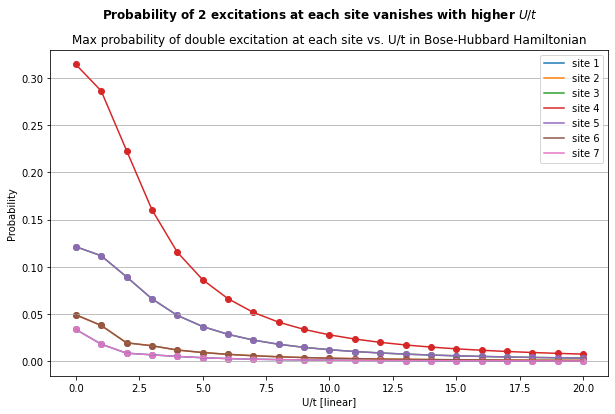

In [167]:
plt.figure(figsize=(10, 6))
plt.suptitle(f"Probability of 2 excitations at each site vanishes with higher $U/t$", fontweight='bold')
plt.title(f"Max probability of double excitation at each site vs. U/t in Bose-Hubbard Hamiltonian")
plt.xlabel("U/t [linear]")
plt.ylabel(f"Probability")

for site_num in range(L):
    u_ratios = []
    cntr_maxprobs = []
    for key_str in exp_vals:
        if int(key_str[5:-1]) != 100:
            u_ratios.append(int(key_str[5:-1]))
            center_dbl_excitation_probs = exp_vals[key_str][site_num+2*L]
            cntr_maxprobs.append(max(center_dbl_excitation_probs))
    
    plt.grid(True, which='major', axis='y')
    plt.scatter(u_ratios, cntr_maxprobs)
    plt.plot(u_ratios, cntr_maxprobs, label=f"site {site_num+1}")
plt.legend()
plt.show()

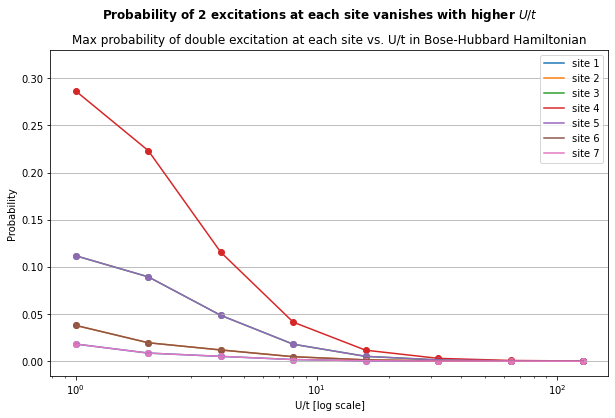

In [186]:
plt.figure(figsize=(10, 6))
plt.suptitle(f"Probability of 2 excitations at each site vanishes with higher $U/t$", fontweight='bold')
plt.title(f"Max probability of double excitation at each site vs. U/t in Bose-Hubbard Hamiltonian")
plt.xlabel("U/t [log scale]")
plt.ylabel(f"Probability")

for site_num in range(L):
    u_ratios = []
    cntr_maxprobs = []
    for key_str in exp_vals:
        u_ratio = int(key_str[5:-1])
        if u_ratio == 0 or np.log2(u_ratio).is_integer():
            u_ratios.append(int(key_str[5:-1]))
            center_dbl_excitation_probs = exp_vals[key_str][site_num+2*L]
            cntr_maxprobs.append(max(center_dbl_excitation_probs))
    plt.grid(True, which='major', axis='y')
    plt.scatter(u_ratios, cntr_maxprobs)
    plt.plot(u_ratios[1:], cntr_maxprobs[1:], label=f"site {site_num+1}")
plt.xscale('log')
plt.legend()
plt.show()

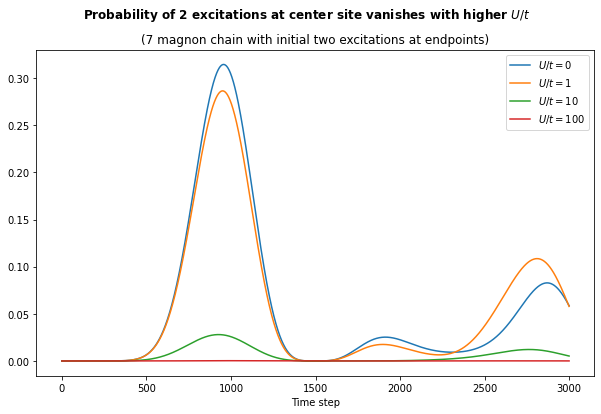

In [38]:
site_num = int(L/2)
# Plot double excitation prob at center site with varying U/t
plt.figure(figsize=(10,6))
plt.suptitle(f"Probability of 2 excitations at center site vanishes with higher $U/t$", fontweight='bold')
plt.title("(7 boson chain with initial two excitations at endpoints)")
plt.xlabel("Time step")
for key_str in exp_vals:
    plt.plot(exp_vals[key_str][site_num+2*L], label=key_str)
plt.legend()
plt.show()

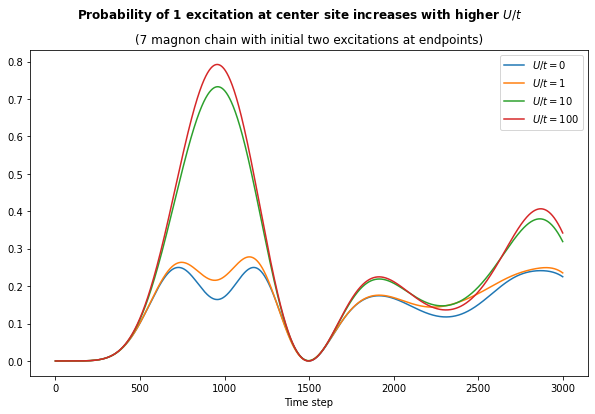

In [39]:
site_num = int(L/2)
# Plot single excitation prob at center site with varying U/t
plt.figure(figsize=(10,6))
plt.suptitle(f"Probability of 1 excitation at center site increases with higher $U/t$", fontweight='bold')
plt.title("(7 boson chain with initial two excitations at endpoints)")
plt.xlabel("Time step")
for key_str in exp_vals:
    plt.plot(exp_vals[key_str][site_num+L], label=key_str)
plt.legend()
plt.show()

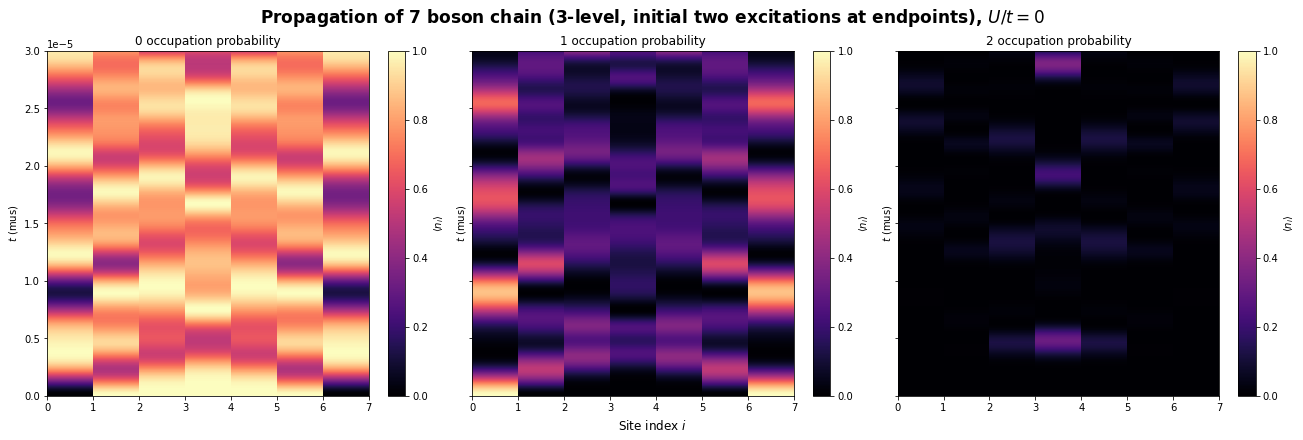

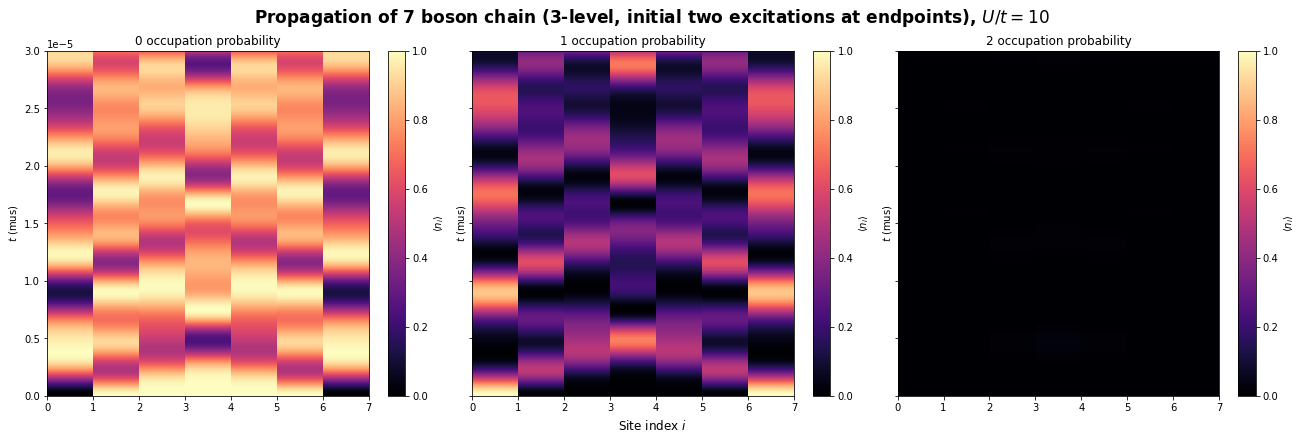

In [47]:
for key_str in exp_vals:
    # plot double-particle density distribution propagate over time
    fig, (zero_occup, single_occup, double_occup) = plt.subplots(1, 3, 
                                   sharey=True, 
                                   #gridspec_kw={'height_ratios': [0.2, 1]},
                                   figsize=(12*1.5, 4*1.5),
                                   constrained_layout=True)
    fig.supxlabel('Site index $i$')
    fig.suptitle(f"Propagation of {L} boson chain (3-level, initial two excitations at endpoints), {key_str}", 
                fontweight='bold',
                fontsize=17)
    for num_excitations, heatmap in enumerate((zero_occup, single_occup, double_occup)):
        # Rydberg probability per atom:
        rho = np.zeros([L, len(times)])
        # extract expectation values
        for i in range(L):
            rho[i] = exp_vals[key_str][num_excitations*L:L*(num_excitations+1)][i]

        heatmap.title.set_text(f"{num_excitations} occupation probability")
        atomnum = np.linspace(1,L,L)
        site_mesh, t_mesh = np.meshgrid(atomnum-0.5, times)
        col1 = heatmap.pcolormesh(site_mesh, t_mesh, rho.transpose(), cmap='magma', vmin=0, vmax=1)
        plt.colorbar(col1, ax=heatmap, label=r'$\left< n_i \right>$')
        heatmap.set(ylabel=r'$t$ (mus)');
    if key_str == "$U/t=0$":
        plt.savefig(f"./evolveplts_utzero.jpg")
    else:
        plt.savefig(f"./evolveplts_utten.jpg")
    plt.show()